## Set Paths

In [26]:
path_to_simulatortofmu = 'C:/Users/Joscha/Documents/Github/SimulatorToFMU'
path_to_fmiforpowersystems = "C:\\Users\\Joscha\\Documents\\Github\\fmi-for-power-system"
path_to_fmiforpowersystem_2 = "C:/Users/Joscha/Documents/Github/fmi-for-power-system"

## Default Parameters

In [36]:
# ###############################################
# ########## Default Parameters #################
# ###############################################
start = '2016-06-16 22:00:00'
end = '2016-06-18 00:00:00'
pv_nominal_kw = 1500  # There are 3 PV locations hardcoded at node 7, 8, 9
inverter_sizing = 1.05
inverter_qmax_percentage = 0.44
thrP = 0.04
hysP = 0.06
thrQ = 0.03
hysQ = 0.03
first_order_time_const = 1 * 60
solver_relative_tolerance = 0.1
solver_absolute_tolerance = 0.1
solver_name = 'CVode'
result_filename = 'result'

## Package Imports

In [37]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas
import numpy
import datetime
from tabulate import tabulate
import json
import re
import os
import signal
import shlex, subprocess

# Imports useful for graphics
import matplotlib
import matplotlib.pyplot as plt
import seaborn
seaborn.set_style("whitegrid")
seaborn.despine()
%matplotlib inline
font = {'size'   : 14}
matplotlib.rc('font', **font)

## Date conversion

In [38]:
begin = '2016-01-01 00:00:00'
begin_dt = datetime.datetime.strptime(begin, '%Y-%m-%d %H:%M:%S')
start_dt = datetime.datetime.strptime(start, '%Y-%m-%d %H:%M:%S')
end_dt = datetime.datetime.strptime(end, '%Y-%m-%d %H:%M:%S')
start_s = int((start_dt - begin_dt).total_seconds())
end_s = int((end_dt - begin_dt).total_seconds())

In [39]:
inverter_smax = pv_nominal_kw * inverter_sizing
inverter_qmax = inverter_smax * inverter_qmax_percentage
pv_inverter_parameters = {
    'weather_file':(path_to_fmiforpowersystems +
        '\\examples\\003_pandapower_modelexchange\\pv_inverter\\' +
        'USA_CA_San.Francisco.Intl.AP.724940_TMY3.mos'),
    'n': 1,
    'A': (pv_nominal_kw * 1000) / (0.158 * 1000),
    'eta': 0.158,
    'lat': 37.9,
    'til': 10,
    'azi': 0,
    'thrP': thrP,  #0.05,
    'hysP': hysP,  #0.04,
    'thrQ': thrQ,  #0.04,
    'hysQ': hysQ,  #0.01,
    'SMax': inverter_smax,
    'QMaxInd': inverter_qmax,
    'QMaxCap': inverter_qmax,
    'Tfirstorder': first_order_time_const,
}


first_order_parameters = {
    'T': first_order_time_const
}


run_simulation = True
connections_filename = 'connections.xlsx'
pv_inverter_path = 'pv_inverter/Pv_Inv_VoltVarWatt_simple_Slim.fmu'
pv_inverter_path = 'pv_inverter/PV_0Inv_0VoltVarWat_0simple_0Slim_Pv_0Inv_0VoltVarWatt_0simple_0Slim.fmu'
pandapower_path = 'pandapower/pandapower.fmu'
pandapower_folder = 'pandapower'
pandapower_parameter = {}
firstorder_path = 'firstorder/FirstOrder.fmu'

## Create the connection mapping

In [40]:
connections = pandas.DataFrame(columns=['fmu1_id', 'fmu1_path',
                                      'fmu2_id', 'fmu2_path',
                                      'fmu1_parameters',
                                      'fmu2_parameters',
                                      'fmu1_output',
                                      'fmu2_input'])

# Connection for each customer
nodes = [7, 9, 24]
for index in nodes:
    connections = connections.append(
        {'fmu1_id': 'PV' + str(index),
         'fmu1_path': pv_inverter_path,
         'fmu2_id': 'pandapower',
         'fmu2_path': pandapower_path,
         'fmu1_parameters': pv_inverter_parameters,
         'fmu2_parameters': pandapower_parameter,
         'fmu1_output': 'P',
         'fmu2_input': 'KW_' + str(index)},
        ignore_index=True)   
    connections = connections.append(
        {'fmu1_id': 'PV' + str(index),
         'fmu1_path': pv_inverter_path,
         'fmu2_id': 'pandapower',
         'fmu2_path': pandapower_path,
         'fmu1_parameters': pv_inverter_parameters,
         'fmu2_parameters': pandapower_parameter,
         'fmu1_output': 'Q',
         'fmu2_input': 'KVAR_' + str(index)},
        ignore_index=True)
    connections = connections.append(
        {'fmu1_id': 'pandapower',
         'fmu1_path': pandapower_path,
         'fmu2_id': 'firstorder' + str(index),
         'fmu2_path': firstorder_path,
         'fmu1_parameters': pandapower_parameter,
         'fmu2_parameters': first_order_parameters,
         'fmu1_output': 'Vpu_' + str(index),
         'fmu2_input': 'u'},
        ignore_index=True)
    connections = connections.append(
        {'fmu1_id': 'firstorder' + str(index),
         'fmu1_path': firstorder_path,
         'fmu2_id': 'PV' + str(index),
         'fmu2_path': pv_inverter_path,
         'fmu1_parameters': first_order_parameters,
         'fmu2_parameters': pv_inverter_parameters,
         'fmu1_output': 'y',
         'fmu2_input': 'v'},
        ignore_index=True)
    
def _sanitize_name(name):
    """
    Make a Modelica valid name.
    In Modelica, a variable name:
    Can contain any of the characters {a-z,A-Z,0-9,_}.
    Cannot start with a number.
    :param name(str): Variable name to be sanitized.
    :return: Sanitized variable name.
    """

    # Check if variable has a length > 0
    assert(len(name) > 0), 'Require a non-null variable name.'

    # If variable starts with a number add 'f_'.
    if(name[0].isdigit()):
        name = 'f_' + name

    # Replace all illegal characters with an underscore.
    g_rexBadIdChars = re.compile(r'[^a-zA-Z0-9_]')
    name = g_rexBadIdChars.sub('_', name)
    return name
connections['fmu1_output'] = connections['fmu1_output'].apply(lambda x: _sanitize_name(x))
connections['fmu2_input'] = connections['fmu2_input'].apply(lambda x: _sanitize_name(x))

print(tabulate(connections[
    ['fmu1_id', 'fmu2_id', 'fmu1_output', 'fmu2_input']].head(),
    headers='keys', tablefmt='psql'))
print(tabulate(connections[
    ['fmu1_id', 'fmu2_id', 'fmu1_output', 'fmu2_input']].tail(),
    headers='keys', tablefmt='psql'))
connections.to_excel(connections_filename, index=False)

+----+-------------+-------------+---------------+--------------+
|    | fmu1_id     | fmu2_id     | fmu1_output   | fmu2_input   |
|----+-------------+-------------+---------------+--------------|
|  0 | PV7         | pandapower  | P             | KW_7         |
|  1 | PV7         | pandapower  | Q             | KVAR_7       |
|  2 | pandapower  | firstorder7 | Vpu_7         | u            |
|  3 | firstorder7 | PV7         | y             | v            |
|  4 | PV9         | pandapower  | P             | KW_9         |
+----+-------------+-------------+---------------+--------------+
+----+--------------+--------------+---------------+--------------+
|    | fmu1_id      | fmu2_id      | fmu1_output   | fmu2_input   |
|----+--------------+--------------+---------------+--------------|
|  7 | firstorder9  | PV9          | y             | v            |
|  8 | PV24         | pandapower   | P             | KW_24        |
|  9 | PV24         | pandapower   | Q             | KVAR_24      

# Recompile Pandapower FMU

In [41]:
cmd = ("C:/JModelica.org-2.4/setenv.bat 64 && " +
       " cd " + pandapower_folder + " && "
       "cyderc " +
       " --path ./"
       " --name pandapower" +
       " --io pandapower.xlsx" +
       " --path_to_simulatortofmu " + path_to_simulatortofmu + "/simulatortofmu/parser/SimulatorToFMU.py " +
       " --fmu_struc python")        
args = shlex.split(cmd)
process = subprocess.Popen(args, bufsize=1, universal_newlines=True)
process.wait()
process.kill()

# Launch FMU simulation

In [42]:
cmd = ("C:/JModelica.org-2.4/setenv.bat 64 && " +
       "cyders " +
       " --start " + str(start_s) +
       " --end " + str(end_s) +
       " --connections " + connections_filename +
       " --nb_steps 25" +
       " --solver " + solver_name +
       " --rtol " + str(solver_relative_tolerance) +
       " --atol " + str(solver_absolute_tolerance) +
       " --result " + 'results/' + result_filename + '.csv')        
args = shlex.split(cmd)
process = subprocess.Popen(args, bufsize=1, universal_newlines=True,
                          creationflags=subprocess.CREATE_NEW_PROCESS_GROUP)
process.wait()
process.send_signal(signal.CTRL_BREAK_EVENT)
process.kill()
print('Killed')

Killed


# Plot results

In [43]:
# Load results
results = pandas.read_csv('results/' + result_filename + '.csv')
from pathlib import Path, PureWindowsPath
results = pandas.read_csv(os.path.join(path_to_fmiforpowersystem_2 + '/examples/003_pandapower_modelexchange/results/result.csv'))
epoch = datetime.datetime.utcfromtimestamp(0)
begin_since_epoch = (begin_dt - epoch).total_seconds()
results['datetime'] = results['time'].apply(
    lambda x: datetime.datetime.utcfromtimestamp(begin_since_epoch + x))
results.set_index('datetime', inplace=True, drop=False)
print('COLUMNS=')
print(results.columns)
print('START=')
print(results.head(1).index[0])
print('END=')
print(results.tail(1).index[0])

COLUMNS=
Index([u'time', u'PV24.A', u'PV24.P', u'PV24.Q', u'PV24.QMaxCap',
       u'PV24.QMaxInd', u'PV24.SMax', u'PV24.S_curtail_P.y',
       u'PV24.Tfirstorder', u'PV24.WtokW.k',
       ...
       u'pandapower.uR[2]', u'pandapower.uR[3]', u'pandapower.uR[4]',
       u'pandapower.uR[5]', u'pandapower.uR[6]', u'pandapower.yR[1]',
       u'pandapower.yR[2]', u'pandapower.yR[3]', u'time.1', u'datetime'],
      dtype='object', length=2034)
START=
2016-06-16 22:00:00
END=
2016-06-18 00:00:00


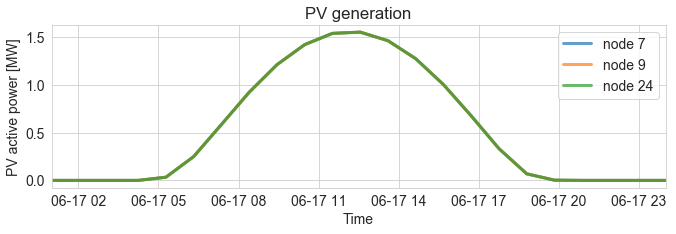

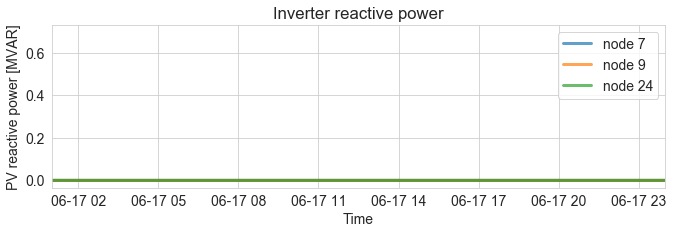

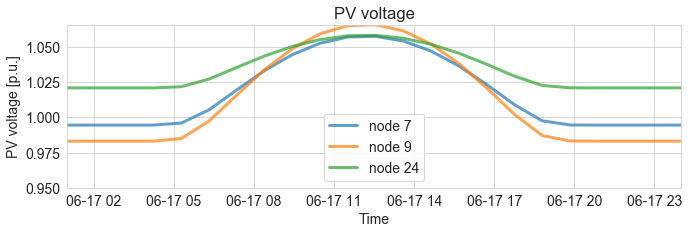

In [44]:
# Plot sum of all PVs for P and P curtailled and Q
cut = '2016-06-17 01:00:00'
fig, axes = plt.subplots(1, 1, figsize=(11, 3))
plt.title('PV generation')
for node in nodes:
    plt.plot(results['datetime'],
             results['pandapower.KW_' + str(node)] / 1000,
            linewidth=3, alpha=0.7, label='node ' + str(node))
plt.legend(loc=0)
plt.ylabel('PV active power [MW]')
plt.xlabel('Time')
plt.xlim([cut, end])
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(11, 3))
plt.title('Inverter reactive power')
for node in nodes:
    plt.plot(results['datetime'],
             results['pandapower.KVAR_' + str(node)] / 1000,
            linewidth=3, alpha=0.7, label='node ' + str(node))
plt.legend(loc=0)
plt.ylabel('PV reactive power [MVAR]')
plt.xlabel('Time')
plt.xlim([cut, end])
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(11, 3))
plt.title('PV voltage')
for node in nodes:
    plt.plot(results['datetime'],
             results['pandapower.Vpu_' + str(node)],
            linewidth=3, alpha=0.7, label='node ' + str(node))
plt.legend(loc=0)
plt.ylabel('PV voltage [p.u.]')
plt.xlabel('Time')
plt.xlim([cut, end])
plt.ylim([0.95, results[['pandapower.Vpu_' + str(node)
                         for node in nodes]].max().max()])
plt.show()
